# GF-KSD vs. KSD Importance Sampling

The following is an empirical comparison of GF-KSD importance sampling and KSD importance sampling.

In [13]:
import torch
from torch.distributions import MultivariateNormal
import numpy as np
from qpsolvers import solve_qp
import random
import math

from steintorch.utils.get_score import get_score
from steintorch.kernel import LinearKernel
from steintorch.divergence.mmd import MMD
from steintorch.divergence.ksd import GradientFreeKSD, KSD
from steintorch.utils import nearestSPD
from steintorch.utils import standard_cov, standard_std_const

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

## Define GF-KSD and KSD

In [22]:
_gfksd = GradientFreeKSD(None, preconditioner=torch.Tensor([1]))
_ksd = KSD(None, preconditioner=torch.Tensor([1]))

linear_kernel = LinearKernel(dim=2) 
mmd_linear = MMD(linear_kernel)

## Define GF-KSD importance sampling and Self-Normalised Importance Sampling

We will use the data standardisation `standard_cov` which computes the standardisation $(C^{-1})^{1/2}$ where $C$ is the covariance matrix of the samples.

In [23]:
def ksd_is(samples, p_evals, q_evals, q_scores, p_samples, mmd, p_scores=None, standardise_func=standard_cov, ksd=False):

    if standardise_func is not None:
        standardise_vec = standardise_func(samples)
        if standardise_vec.dim() < 2:
            add_const = torch.log(torch.prod(1 / standardise_vec))

            tsamples = samples * standardise_vec
            tscores = q_scores / standardise_vec
            
            if p_scores is not None:
                tp_scores = p_scores / standardise_vec

            tp_evals = p_evals + add_const
            tq_evals = q_evals + add_const
        else:
            inverse_standard = torch.linalg.inv(standardise_vec)
            add_const = torch.slogdet(inverse_standard)[1]
            tsamples = torch.matmul(samples, standardise_vec)
            tscores = torch.matmul(q_scores, inverse_standard.T)

            if p_scores is not None:
                tp_scores = torch.matmul(p_scores, inverse_standard.T)

            tp_evals = p_evals + add_const
            tq_evals = q_evals + add_const
    else:
        tsamples = samples
        tscores = q_scores
        tp_evals = p_evals
        tq_evals = q_evals
        tp_scores = p_scores

    const = (tp_evals - tq_evals).min()
    ttp_evals = tp_evals - const - 12
    if ksd is False:
        ksd_mat = _gfksd.stein_matrix(tsamples, ttp_evals, tq_evals, tscores).detach()
    else:
        ksd_mat = _ksd.stein_matrix(tsamples, tp_scores).detach()

    P = np.array(nearestSPD(ksd_mat / ksd_mat.sum()) * 5e8) 
    A = np.ones(P.shape[0])
    b = np.array([1]) 
    lb = np.zeros(P.shape[0])
    optim_weight = torch.Tensor(solve_qp(P, lb, None, None, A, b, lb, None, solver="scs",eps_abs=1e-07, eps_rel=1e-07))

    mmd_output = mmd.eval(x = samples, y = p_samples, weights_x = optim_weight.flatten())

    return optim_weight, mmd_output


In [24]:
def get_mmd_self_normalised(samples, p_evals, q_evals, p_samples, mmd):
    diff = (p_evals - q_evals).detach()
    diff = diff - diff.mean()
    self_normalised_weights = diff.exp() / diff.exp().sum()

    mmd_output = mmd.eval(x = samples, y = p_samples, weights_x = self_normalised_weights).detach()
    return self_normalised_weights, mmd_output

## Define Experiment function

The following function computes many importance sampling problems and computes GF-KSD IS, KSD IS and Self-Normalised IS.

In [25]:
def is_compare_experiment(q_samples, p_evals, p_scores, q_evals, q_scores, random_samples, N_list, p_samples, 
                          mmd=mmd_linear, standardise_func=standard_cov, print_progress=False):
                  
    N = len(N_list)
    M = len(random_samples)
    mmd_gfksd_list = [[] for i in range(N)]
    mmd_ksd_list = [[] for i in range(N)]
    mmd_norm_list = [[] for i in range(N)]

    for i in range(N):
        if print_progress is True:
            print(str(i) + '/' + str(N))
        for j in range(M):
            q_samples_ij = q_samples[random_samples[j]][:N_list[i]]
            q_evals_ij = q_evals[random_samples[j]][:N_list[i]]
            q_scores_ij = q_scores[random_samples[j]][:N_list[i]]
            p_evals_ij = p_evals[random_samples[j]][:N_list[i]]
            # GF-KSD IS
            out_gfksd = ksd_is(q_samples_ij, p_evals_ij, q_evals_ij, q_scores_ij, p_samples, mmd,
                            standardise_func=standardise_func)
            mmd_gfksd_list[i].append(out_gfksd[1].detach())
            # KSD IS
            p_scores_ij = p_scores[random_samples[j]][:N_list[i]]
            out_ksd = ksd_is(q_samples_ij, p_evals_ij, q_evals_ij, q_scores_ij, p_samples, mmd,
                            p_scores=p_scores_ij, standardise_func=standardise_func, ksd=True)
            mmd_ksd_list[i].append(out_ksd[1].detach())
            # Self-Normalised IS
            out_norm = get_mmd_self_normalised(q_samples_ij, p_evals_ij, q_evals_ij, p_samples, mmd)
            mmd_norm_list[i].append(out_norm[1].detach())

    return(mmd_gfksd_list, mmd_ksd_list, mmd_norm_list)

## Define Experiment

We will compare GF-KSD IS, KSD IS and Self-Normalised Importance Sampling on the following problems

1. Regime 1: $$ p = \mathcal{N}(0,I),  q = \mathcal{N}(0, b I) $$
2. Regime 2: $$ p = \mathcal{N}(0,I),  q = \mathcal{N}(a, I) $$

We consider dimensions $d = 1, 5, 10, 50$ and number of data sampled from $q$, $n=10, 100, 1000$. The values of $b$ will vary from $0.5$, to $1.5$ and the values of $a$ will vary from $-1$ to $1$.

In [40]:
N_list = [10, 100, 500] # number of data points considered
D_list = [1,5,20,50] # dimension of p and q
b_list = [0.7,0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2, 1.3]
a_list = [-0.6, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.6]

random_samples = [] # indexes of the random samples we consider

for i in range(20): # we re-run the experiments 20 times to obtain an average.
    random_samples.append(random.sample(range(10000), 1000))

#### Regime 1 Experiment:

In [38]:
N = len(N_list)
M = len(random_samples)
D = len(D_list)
N_b_list = len(b_list)

output_gf_ksd1 = [[] for i in range(D)]
output_ksd1 = [[] for i in range(D)]
output_selfnorm1 = [[] for i in range(D)]

for i in range(D):
    print(str(i + 1) + '/' + str(D))
    torch.manual_seed(0)
    p_i = MultivariateNormal(torch.zeros(D_list[i]), torch.eye(D_list[i]))
    p_i_sample = p_i.sample((8000,)) # the true samples we compute MMD against
    for j in range(N_b_list):
        torch.manual_seed(0)
        q_ij = MultivariateNormal(torch.zeros(D_list[i]), b_list[j] * torch.eye(D_list[i])) # regime 1 q
        q_ij_sample = q_ij.sample((10000,)).requires_grad_(True)
        p_i_scores = get_score(q_ij_sample, p_i).detach() #for KSD IS
        q_ij_scores = get_score(q_ij_sample, q_ij).detach()
        p_i_log_prob = p_i.log_prob(q_ij_sample).detach()
        q_ij_log_prob = q_ij.log_prob(q_ij_sample).detach()

        mmd_gfksd, mmd_ksd, mmd_selfnorm = is_compare_experiment(q_ij_sample.detach(), p_i_log_prob, p_i_scores, q_ij_log_prob, q_ij_scores, random_samples,
                                                                 N_list, p_i_sample, mmd=mmd_linear, standardise_func=standard_std_const)
        
        output_gf_ksd1[i].append(mmd_gfksd)
        output_ksd1[i].append(mmd_ksd)
        output_selfnorm1[i].append(mmd_selfnorm)


1/4


/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/scs_.py:165: UserWarning: SCS returned 2: SOLVED_INACCURATE
  warn(


2/4
3/4
4/4


#### Regime 2 Experiment:

In [41]:
N = len(N_list)
M = len(random_samples)
D = len(D_list)
N_a_list = len(a_list)

output_gf_ksd2 = [[] for i in range(D)]
output_ksd2 = [[] for i in range(D)]
output_selfnorm2 = [[] for i in range(D)]

for i in range(D):
    print(str(i + 1) + '/' + str(D))
    torch.manual_seed(0)
    p_i = MultivariateNormal(torch.zeros(D_list[i]), torch.eye(D_list[i]))
    p_i_sample = p_i.sample((8000,)) # the true samples we compute MMD against
    for j in range(N_a_list):
        torch.manual_seed(0)
        q_ij = MultivariateNormal(torch.zeros(D_list[i]) + a_list[j], torch.eye(D_list[i])) # regime 2 q
        q_ij_sample = q_ij.sample((10000,)).requires_grad_(True)
        p_i_scores = get_score(q_ij_sample, p_i).detach() #for KSD IS
        q_ij_scores = get_score(q_ij_sample, q_ij).detach()
        p_i_log_prob = p_i.log_prob(q_ij_sample).detach()
        q_ij_log_prob = q_ij.log_prob(q_ij_sample).detach()

        mmd_gfksd, mmd_ksd, mmd_selfnorm = is_compare_experiment(q_ij_sample.detach(), p_i_log_prob, p_i_scores, q_ij_log_prob, q_ij_scores, random_samples,
                                                                 N_list, p_i_sample, mmd=mmd_linear, standardise_func=standard_std_const)
        
        output_gf_ksd2[i].append(mmd_gfksd)
        output_ksd2[i].append(mmd_ksd)
        output_selfnorm2[i].append(mmd_selfnorm)

1/4


/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


2/4
3/4
4/4


## Plot Output

In [35]:
def plotting_func(axis, i, j, is_output, x_axis, color='red', linestyle='-', NN=N_b_list, linewidth = 2, label='', dashes=None, s=20):
    output_plotting  = [is_output[i][k][j] for k in range(NN)]
    const = 1/math.sqrt(len(output_plotting[0]))

    mmd_tensor = torch.Tensor(output_plotting)
    mean = mmd_tensor.log().mean(dim=1)
    std = torch.log(mmd_tensor).std(dim=1)

    if dashes is not None:
        axis.plot(x_axis, mean, linestyle=linestyle,color=color,linewidth=linewidth, dashes=dashes, label=label)
    else:
        axis.plot(x_axis, mean, linestyle=linestyle,color=color,linewidth=linewidth, label=label)

    axis.scatter(x_axis, mean, color=color, s=s)

    axis.fill_between(x_axis, mean - const * std, mean + const * std, color = color, alpha=0.2)

### Regime 1:

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_6258/623347533.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("gf_ksd_comparison1.pdf", bbox_inches = "tight", padding = 0)


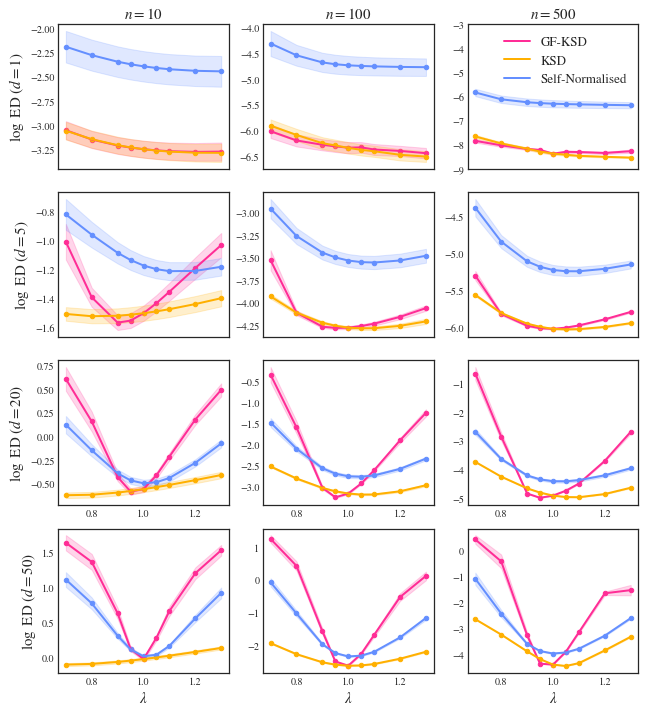

In [39]:
fig, axes = plt.subplots(D, N, figsize=(N * 3, D * 2.5))

color_cycle = ['#FF2D96','#FFB000','#648FFF']
minimum_row0 = [-4, -7, -9]
max_row0 = [2, -2.5, -3]

for i in range(D):
    axes[i][0].set_ylabel('$\log$ ED ($d = $' + str(D_list[i]) + ')', fontsize=15)
    for j in range(N):
        axis = axes[i][j]
        if i < 2:
            axis.xaxis.set_ticks([])
            
        plotting_func(axis, i, j, output_gf_ksd1, b_list, color=color_cycle[0], label='GF-KSD')
        plotting_func(axis, i, j, output_ksd1, b_list, color=color_cycle[1], label='KSD')
        plotting_func(axis, i, j, output_selfnorm1, b_list, color=color_cycle[2], label='Self-Normalised', linestyle='solid', dashes=None)
        if i == 0:
            if j == 2:
                axis.legend(fontsize=13)

        if i == 3:
            axis.set_xlabel('$\lambda$', fontsize=15)

        if i == 0:
            axis.set_title('$n = $' + str(N_list[j]), fontsize=15)
            if j == 2:
                axis.set_ylim([minimum_row0[j], max_row0[j]])

fig.tight_layout()
fig.savefig("gf_ksd_comparison1.pdf", bbox_inches = "tight", padding = 0)


#### Plot Horizontal

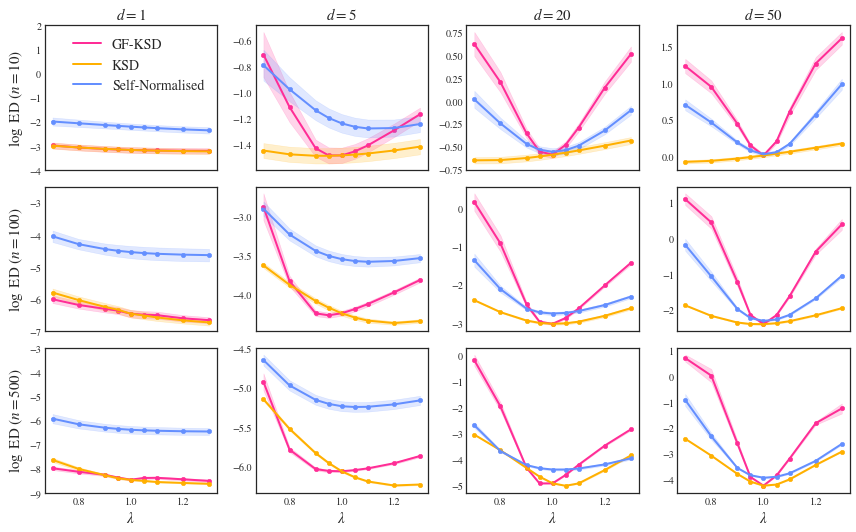

In [173]:
fig, axes = plt.subplots(N, D, figsize=(D * 3, N * 2.5))

color_cycle = ['#FF2D96','#FFB000','#648FFF']
minimum_col0 = [-4, -7, -9]
max_col0 = [2, -2.5, -3]

for i in range(N):
    axes[i][0].set_ylabel('$\log$ ED ($n = $' + str(N_list[i]) + ')', fontsize=15)
    for j in range(D):
        axis = axes[i][j]
        if i < 2:
            axis.xaxis.set_ticks([])
            
        plotting_func(axis, j, i, output_gf_ksd, b_list, color=color_cycle[0], label='GF-KSD')
        plotting_func(axis, j, i, output_ksd, b_list, color=color_cycle[1], label='KSD')
        plotting_func(axis, j, i, output_selfnorm, b_list, color=color_cycle[2], label='Self-Normalised', linestyle='solid', dashes=None)
        if i == 0 and j == 0:
            axis.legend(fontsize=14)

        if i == 0:
            axis.set_title('$d = $' + str(D_list[j]), fontsize=15)
        if j == 0:
            axis.set_ylim([minimum_col0[i], max_col0[i]])

        if i == 2:
            axis.set_xlabel('$\\lambda$', fontsize=15)

fig.tight_layout()

### Regime 2:

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_6258/3698432060.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("gf_ksd_comparison2.pdf", bbox_inches = "tight", padding = 0)


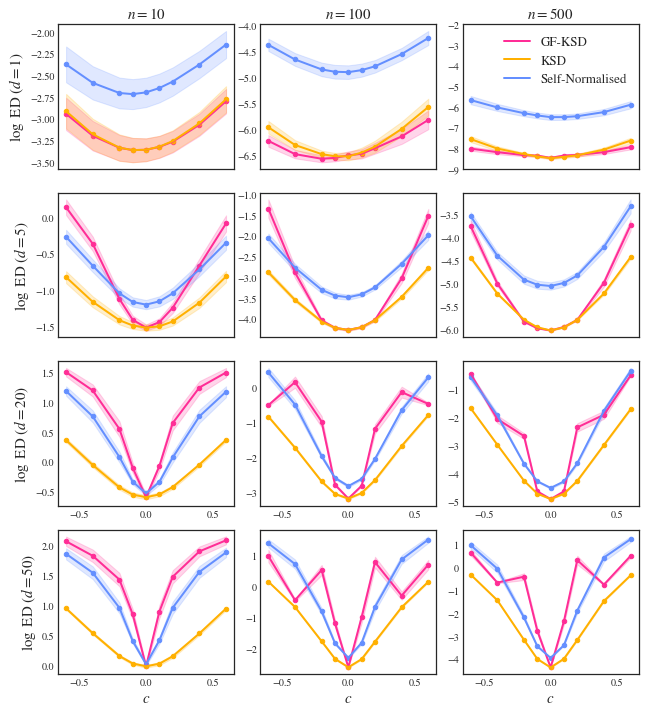

In [42]:
fig, axes = plt.subplots(D, N, figsize=(N * 3, D * 2.5))

color_cycle = ['#FF2D96','#FFB000','#648FFF']
minimum_row0 = [-4, -7, -9]
max_row0 = [2, -2.5, -3]

for i in range(D):
    axes[i][0].set_ylabel('$\log$ ED ($d = $' + str(D_list[i]) + ')', fontsize=15)
    for j in range(N):
        axis = axes[i][j]
        if i < 2:
            axis.xaxis.set_ticks([])
            
        plotting_func(axis, i, j, output_gf_ksd2, a_list, color=color_cycle[0], label='GF-KSD', NN=N_a_list)
        plotting_func(axis, i, j, output_ksd2, a_list, color=color_cycle[1], label='KSD', NN=N_a_list)
        plotting_func(axis, i, j, output_selfnorm2, a_list, color=color_cycle[2], label='Self-Normalised', linestyle='solid', dashes=None, NN=N_a_list)
        if i == 0:
            if j == 2:
                axis.legend(fontsize=13)

        if i == 3:
            axis.set_xlabel('$c$', fontsize=15)

        if i == 0:
            axis.set_title('$n = $' + str(N_list[j]), fontsize=15)
            if j == 2:
                axis.set_ylim([minimum_row0[j], -2])

fig.tight_layout()
fig.savefig("gf_ksd_comparison2.pdf", bbox_inches = "tight", padding = 0)
